In [1]:
import matplotlib.pyplot as plt
import numpy as np

import lmfit

In [2]:
def linear_resonator(f, f_0, Q, Q_e_real, Q_e_imag):
    Q_e = Q_e_real + 1j*Q_e_imag
    return (1 - (Q * Q_e**-1 / (1 + 2j * Q * (f - f_0) / f_0)))

In [3]:
class ResonatorModel(lmfit.model.Model):
    __doc__ = "resonator model" + lmfit.models.COMMON_DOC

    def __init__(self, *args, **kwargs):
        # pass in the defining equation so the user doesn't have to later.
        super(ResonatorModel, self).__init__(linear_resonator, *args, **kwargs)

        self.set_param_hint('Q', min=0)  # Enforce Q is positive

    def guess(self, data, f=None, **kwargs):
        verbose = kwargs.pop('verbose', None)
        if f is None:
            return
        argmin_s21 = np.abs(data).argmin()
        fmin = f.min()
        fmax = f.max()
        f_0_guess = f[argmin_s21]  # guess that the resonance is the lowest point
        Q_min = 0.1 * (f_0_guess/(fmax-fmin))  # assume the user isn't trying to fit just a small part of a resonance curve.
        delta_f = np.diff(f)  # assume f is sorted
        min_delta_f = delta_f[delta_f > 0].min()
        Q_max = f_0_guess/min_delta_f  # assume data actually samples the resonance reasonably
        Q_guess = np.sqrt(Q_min*Q_max)  # geometric mean, why not?
        Q_e_real_guess = Q_guess/(1-np.abs(data[argmin_s21]))
        if verbose:
            print("fmin=", fmin, "fmax=", fmax, "f_0_guess=", f_0_guess)
            print("Qmin=", Q_min, "Q_max=", Q_max, "Q_guess=", Q_guess, "Q_e_real_guess=", Q_e_real_guess)
        params = self.make_params(Q=Q_guess, Q_e_real=Q_e_real_guess, Q_e_imag=0, f_0=f_0_guess)
        params['%sQ' % self.prefix].set(min=Q_min, max=Q_max)
        params['%sf_0' % self.prefix].set(min=fmin, max=fmax)
        return lmfit.models.update_param_vals(params, self.prefix, **kwargs)

Text(0.5, 1.0, 'simulated measurement')

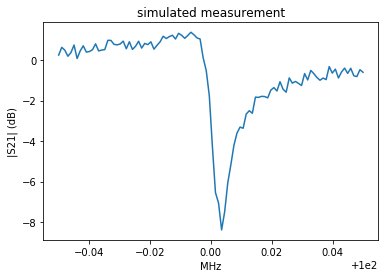

In [4]:
resonator = ResonatorModel()
true_params = resonator.make_params(f_0=100, Q=10000, Q_e_real=9000, Q_e_imag=-9000)

f = np.linspace(99.95, 100.05, 100)
true_s21 = resonator.eval(params=true_params, f=f)
noise_scale = 0.02
np.random.seed(123)
measured_s21 = true_s21 + noise_scale*(np.random.randn(100) + 1j*np.random.randn(100))

plt.figure()
plt.plot(f, 20*np.log10(np.abs(measured_s21)))
plt.ylabel('|S21| (dB)')
plt.xlabel('MHz')
plt.title('simulated measurement')

In [5]:
guess = resonator.guess(measured_s21, f=f, verbose=True)

fmin= 99.95 fmax= 100.05 f_0_guess= 100.00353535353536
Qmin= 100.00353535354105 Q_max= 99003.50000055433 Q_guess= 3146.537781821432 Q_e_real_guess= 5082.2474265369565


In [6]:
result = resonator.fit(measured_s21, params=guess, f=f, verbose=True)

print(result.fit_report() + '\n')
result.params.pretty_print()

[[Model]]
    Model(linear_resonator)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 36
    # data points      = 200
    # variables        = 4
    chi-square         = 0.08533642
    reduced chi-square = 4.3539e-04
    Akaike info crit   = -1543.89425
    Bayesian info crit = -1530.70099
[[Variables]]
    f_0:       100.000096 +/- 7.0360e-05 (0.00%) (init = 100.0035)
    Q:         10059.4924 +/- 142.294768 (1.41%) (init = 3146.538)
    Q_e_real:  9180.61984 +/- 133.776881 (1.46%) (init = 5082.247)
    Q_e_imag: -9137.03237 +/- 133.770215 (1.46%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(Q, Q_e_real)   =  0.518
    C(f_0, Q_e_imag) =  0.517
    C(f_0, Q_e_real) =  0.515
    C(Q, Q_e_imag)   = -0.515


Name         Value      Min      Max   Stderr     Vary     Expr Brute_Step
Q         1.006e+04      100  9.9e+04    142.3     True     None     None
Q_e_imag     -9137     -inf      inf    133.8     True     None     None
Q_e_re

Text(0.5, 0, 'MHz')

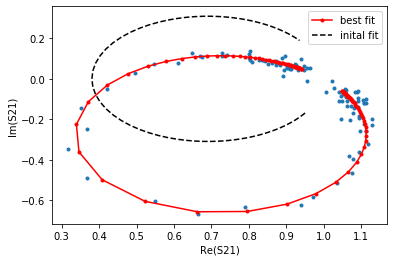

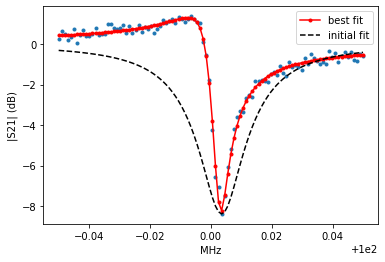

In [7]:
def plot_ri(data, *args, **kwargs):
    plt.plot(data.real, data.imag, *args, **kwargs)


fit_s21 = resonator.eval(params=result.params, f=f)
guess_s21 = resonator.eval(params=guess, f=f)

plt.figure()
plot_ri(measured_s21, '.')
plot_ri(fit_s21, 'r.-', label='best fit')
plot_ri(guess_s21, 'k--', label='inital fit')
plt.legend(loc='best')
plt.xlabel('Re(S21)')
plt.ylabel('Im(S21)')

plt.figure()
plt.plot(f, 20*np.log10(np.abs(measured_s21)), '.')
plt.plot(f, 20*np.log10(np.abs(fit_s21)), 'r.-', label='best fit')
plt.plot(f, 20*np.log10(np.abs(guess_s21)), 'k--', label='initial fit')
plt.legend(loc='best')
plt.ylabel('|S21| (dB)')
plt.xlabel('MHz')

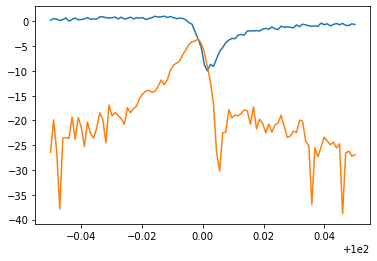

In [11]:
plt.figure()
plt.plot(f, 20*np.log10(np.real(measured_s21)))
plt.plot(f, 20*np.log10(np.abs(measured_s21.imag)))

In [12]:
measured_s21.imag

array([-0.04766496, -0.1014016 , -0.0489959 , -0.01273603, -0.06672349,
       -0.06714972, -0.06592111, -0.10851485, -0.06460563, -0.10718692,
       -0.08568709, -0.05444395, -0.09629602, -0.07398998, -0.06632804,
       -0.0837335 , -0.119625  , -0.10194191, -0.05939771, -0.14260853,
       -0.11139696, -0.1209761 , -0.11188184, -0.10404113, -0.09192724,
       -0.13503598, -0.11940495, -0.13223251, -0.13994731, -0.16864128,
       -0.18606647, -0.1978347 , -0.20178644, -0.19234303, -0.19719638,
       -0.22137697, -0.25638121, -0.22936794, -0.25821458, -0.32238027,
       -0.36275738, -0.37968556, -0.39863471, -0.46504988, -0.5137309 ,
       -0.58493542, -0.6231445 , -0.63531511, -0.66781552, -0.60262824,
       -0.48931818, -0.34896525, -0.24732566, -0.14603339, -0.04804519,
        0.03098316,  0.07493241,  0.07622593,  0.12844694,  0.1061755 ,
        0.11366952,  0.11103117,  0.11754755,  0.12781241,  0.12518621,
        0.09161502,  0.13750691,  0.08244487,  0.10318576,  0.09